# Blindness Detection Image Recognition

## 1. Exploratory Data Analysis

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import numpy as np
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
import matplotlib.gridspec as gridspec
from keras.utils.vis_utils import model_to_dot
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### 1.1 Read in the dataset & images

In [2]:
#list files in the directory
os.listdir('data/')

['processed_images', 'train.csv', 'train_images']

In [3]:
#read in training dataset
#df_train = pd.read_csv('train.csv', index_col = 0)
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
df_train['diagnosis'].unique()

array([2, 4, 1, 0, 3], dtype=int64)

* There are 5 categories that the images can belong to. Here I am matching them with the diagnosis information in the data set.

In [5]:
#add label column into training dataset
def add_label(df):
    if df['diagnosis'] == 0:
        val = "No DR"
    elif df['diagnosis'] == 1:
        val = "Mild"
    elif df['diagnosis'] == 2:
        val = "Moderate"
    elif df['diagnosis'] == 3:
        val = "Severe"
    elif df['diagnosis'] == 4:
        val = "Poliferative DR"
    return val
df_train['diagnosis_names'] = df_train.apply(add_label, axis=1)

In [6]:
df_train.head()

,id_code,diagnosis,diagnosis_names
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Poliferative DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No DR
4,005b95c28852,0,No DR


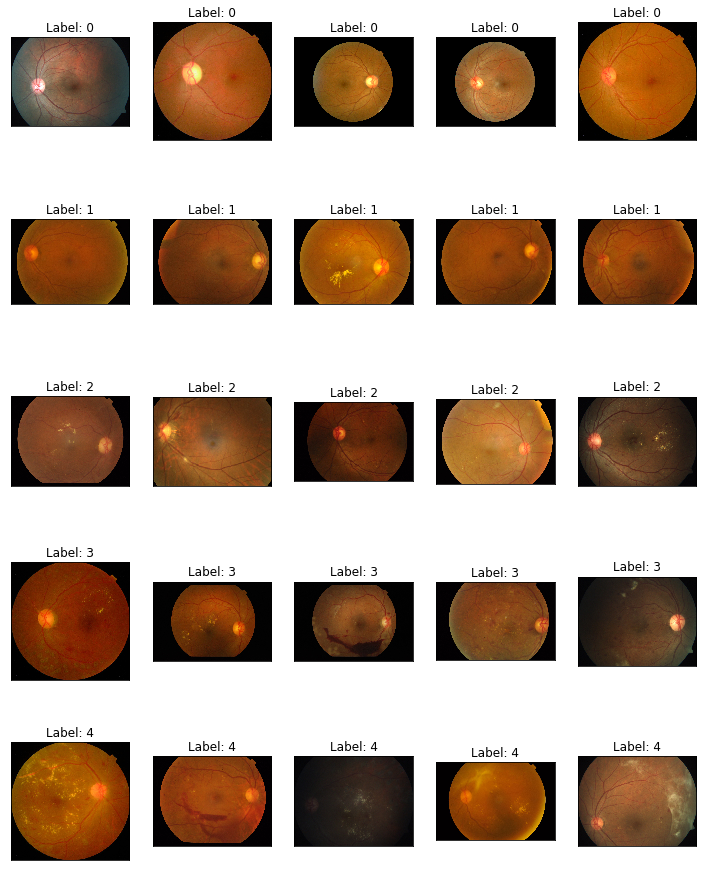

In [7]:
#show training images
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(df_train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5).iterrows()):
        ax = fig.add_subplot(5, 10, class_id * 10 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"data/train_images/{row['id_code']}.png")
        plt.imshow(im)
        ax.set_title(f'Label: {class_id}')

In [8]:
print("Shape of dataset:",df_train.shape)

Shape of dataset: (3662, 3)


In [9]:
def draw_img(imgs):
    fig, axis = plt.subplots(2, 5, figsize=(15, 5))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = (f'data/train_images/{row["id_code"]}.png')
        img = cv2.imread(imgPath)
        row = idnx // 5
        col = idnx % 5
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row, col].imshow(img)
    plt.show()

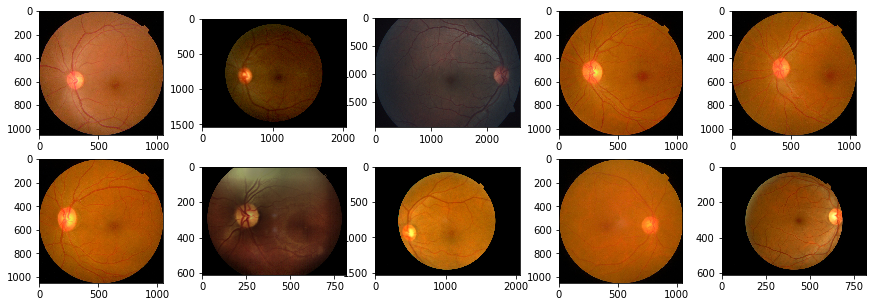

In [10]:
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(10))

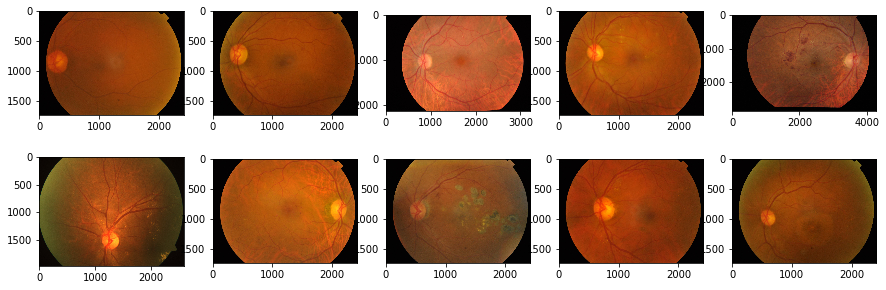

In [11]:
CLASS_ID = 1
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(10))

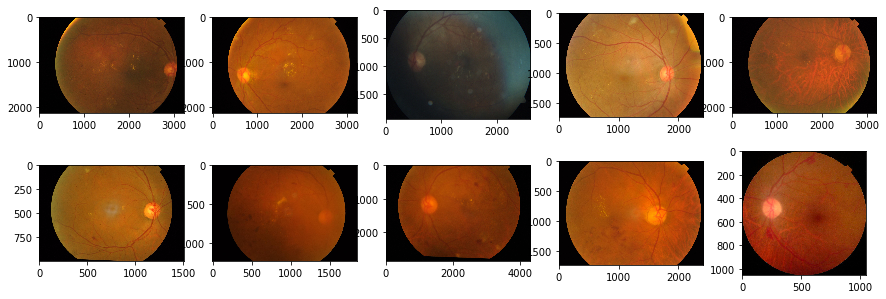

In [12]:
CLASS_ID = 2
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(10))

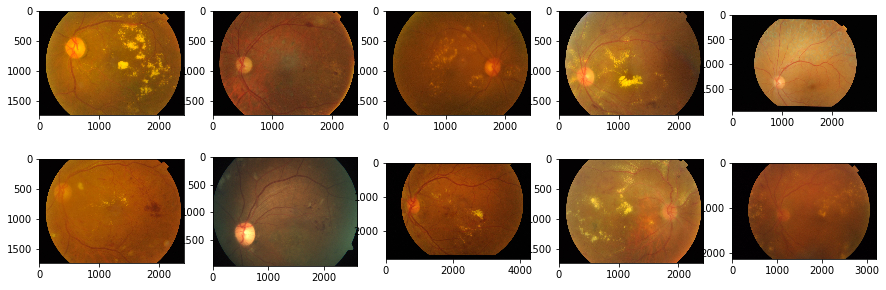

In [13]:
CLASS_ID = 3
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(10))

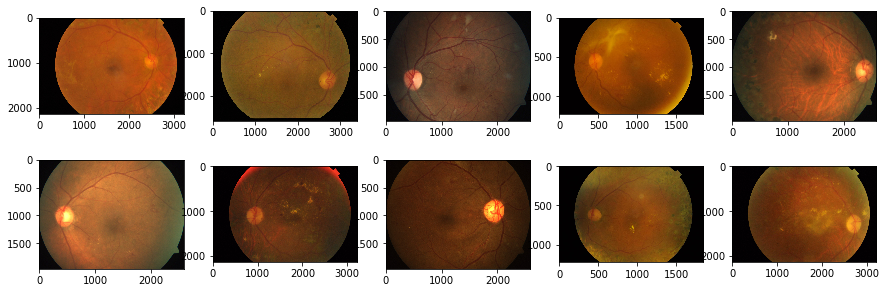

In [14]:
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(10))

* From the images shown above, we can see the training data has different sizes, positions different light conditions.
    * image with better darker light/better light condition
    * image with whole eye ball no crop/cropped
    * image with rectangular shape/trangular shape
    
* Potential Later steps:
    * Resize all the images into the same size
    * Make the light condition into the same level
    * Some image is not clear at all, might need to drop it before training

### 1.2 Read in Image Sizes

In [15]:
# check the average size of each images, if need : reduce the size of image
%time
PATH = "data/train_images"
image_size_list=[]
images_files = os.listdir(PATH)
for image in images_files :
    image_size_list.append(Image.open(os.path.join(PATH, image)).size)

Wall time: 0 ns


In [16]:
images_size = np.array(image_size_list)
images_area =  images_size[:,0] * images_size[:,1]

In [17]:
DF = pd.DataFrame(images_size,columns=['Width','Height'])
DF.head()

,Width,Height
0,3216,2136
1,3216,2136
2,2416,1736
3,1050,1050
4,2048,1536


In [18]:
DF.describe()

,Width,Height
count,3662.000000,3662.000000
mean,2015.176679,1526.830147
std,884.301940,542.663120
min,474.000000,358.000000
25%,1050.000000,1050.000000
50%,2144.000000,1536.000000
75%,2588.000000,1958.000000
max,4288.000000,2848.000000


In [19]:
df_train.shape

(3662, 3)

* Currently: 
    * we have 3662 images in total for train and test
    * each image is around more than 2015*1526,which is very large
* Potential Next steps:
    * Reduce the size of images for faster training

### 1.3 Explore Y labels

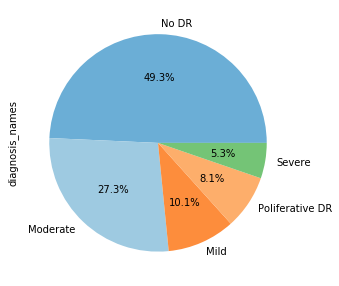

In [20]:
plt.figure(figsize=(5, 5))
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9]))

df_train['diagnosis_names'].value_counts().plot.pie(explode=[0, 0, 0, 0, 0], autopct='%1.1f%%',colors=inner_colors)
plt.show()

In [21]:
df_train['diagnosis_names'].value_counts()

No DR              1805
Moderate            999
Mild                370
Poliferative DR     295
Severe              193
Name: diagnosis_names, dtype: int64

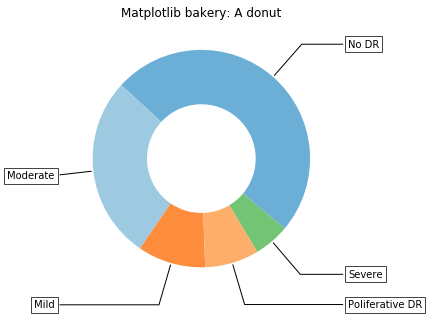

In [22]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))

recipe = ["No DR","Moderate","Mild" ,"Poliferative DR","Severe" ]

#data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(df_train['diagnosis_names'].value_counts(), wedgeprops=dict(width=0.5), startangle=-40,colors=inner_colors)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()

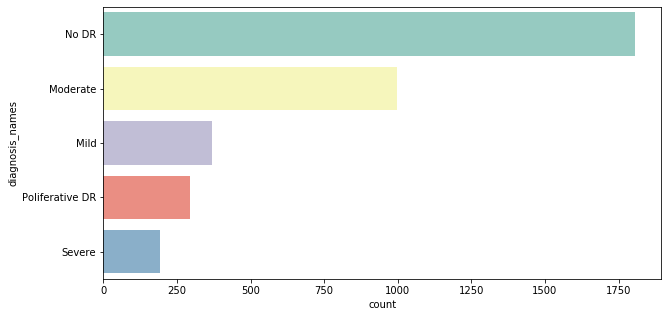

In [23]:
fig=plt.figure(figsize=(10, 5))
#df_train['diagnosis'].value_counts().plot.bar(color ='orange')
#ax = sns.barplot("size", y="diagnosis", data=df_train,palette="Blues_d")
ax = sns.countplot(y="diagnosis_names", data=df_train,palette="Set3",order = df_train["diagnosis_names"].value_counts().index)

* The following graphs show how imbalanced the data is, with most of the images beloning to No DR.
* After running base line model, and check with accuracy and see if there is a problem when doing classification. 
* We might want to try some data augmentaion techniques to make the dataset to be balenced to incrasase accuracy of the dataset.

In [24]:
df_train["isDR"] = 0
df_train.loc[df_train["diagnosis"] != 0,"isDR"]=1
df_train.head()

,id_code,diagnosis,diagnosis_names,isDR
0,000c1434d8d7,2,Moderate,1
1,001639a390f0,4,Poliferative DR,1
2,0024cdab0c1e,1,Mild,1
3,002c21358ce6,0,No DR,0
4,005b95c28852,0,No DR,0


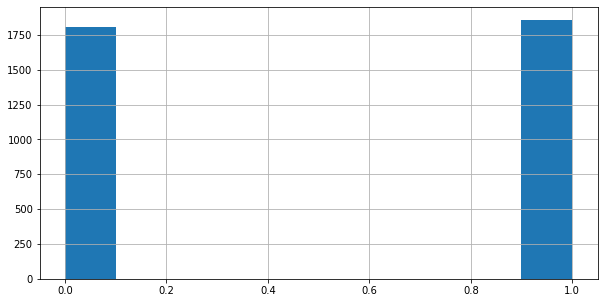

In [25]:
df_train['isDR'].hist(figsize = (10,5))

* If only looking at images diagonosied with DR and no DR, the dataset is pretty balenced.
* The classification between diabetic retinopathy and not been diagonoised as DR seems to be balenced.  
* Within diagonosised: Proliferative DR and severe has less images

## 2. Feature engineering 

In [30]:
for image_id in tqdm(df_train['id_code']):
    path=f"data/train_images/{image_id}.png"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
    cv2.imwrite("data/processed_color_images/{}.png".format(image_id), image)